# Data and Constants

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from scipy.stats import stats
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.stats import norm
import matplotlib.pyplot as plt
from pycaret.regression import *
from multiprocessing import Pool, cpu_count
from concurrent.futures import ThreadPoolExecutor

In [2]:
lipid_path = 'data/section12/lipids_section_12.parquet'
gene_path = 'data/section12/genes_section_12.parquet'

# Helper Functions

In [3]:
def gaussian_weight(distance, std_dev):
    return norm.pdf(distance, 0, std_dev)

In [4]:
def exponential_decay(distance, threshold, decay_rate):
    adjusted_distance = distance - threshold
    return np.exp(-decay_rate * adjusted_distance)

In [5]:

def filter_dataframe_from_file(df, filepath):
    # Read the text file and store the entries in a list
    with open(filepath, 'r') as file:
        entries = file.read().splitlines()

    # Filter the DataFrame based on the index matching the entries
    filtered_df = df.loc[df.index.isin(entries)]

    return filtered_df

# Loading Dataset

In [6]:
# Loading the dataset
lipids_section_12 = pd.read_parquet(lipid_path, engine='pyarrow')
genes_section_12 = pd.read_parquet(gene_path, engine='pyarrow')

# Create cKDTree for fast query of neighbors

In [7]:
# Create a KDTree object for the genes
genes_coords = genes_section_12[['y_ccf', 'z_ccf']].values
genes_kdtree = cKDTree(genes_coords)

# Extract coordinates for lipids
lipids_coords = lipids_section_12[['y_ccf', 'z_ccf']].values

# Nearest Neighbor selection

In [8]:
# Find the indices of the closest gene for each lipid point
_, indices = genes_kdtree.query(lipids_coords, k=1)

# Initialize an empty array for aggregated gene data
aggregated_gene_data = np.zeros((len(lipids_coords), genes_section_12.iloc[:, 46:-50].shape[1]))

# Aggregate gene data based on the closest neighbor
for i, gene_index in enumerate(indices):
    aggregated_gene_data[i] = genes_section_12.iloc[gene_index, 46:-50]

# Convert the aggregated data into a DataFrame
aggregated_gene_data_df = pd.DataFrame(aggregated_gene_data, columns=genes_section_12.columns[46:-50])

# Average of nearest neighbors

In [44]:
# Query to get the 5000 closest genes for each lipid point
_, indices = genes_kdtree.query(lipids_coords, k=10000)

# Pre-allocate memory for aggregated gene data
n_genes = genes_section_12.iloc[:, 46:-50].shape[1]
aggregated_gene_data = np.zeros((len(lipids_coords), n_genes))

# Define a function to aggregate data
def aggregate_data(i):
    gene_indices = indices[i]
    data = genes_section_12.iloc[gene_indices, 46:-50].values
    return data.mean(axis=0)

# Parallel processing
with Pool(cpu_count()) as pool:
    results = pool.map(aggregate_data, range(len(lipids_coords)))

# Assign the results back to the array
for i, res in enumerate(results):
    aggregated_gene_data[i] = res

# Convert the aggregated data into a DataFrame
aggregated_gene_data_df = pd.DataFrame(aggregated_gene_data, columns=genes_section_12.columns[46:-50])

# Exponential Decay

In [14]:
# Find the distances and indices of the 6 closest genes for each lipid point
distances, indices = genes_kdtree.query(lipids_coords, k=6)

# Calculate the average distance
average_closest_distance = np.mean(distances)

# Query to get the 100 closest genes and their distances
distances, indices = genes_kdtree.query(lipids_coords, k=1000)

# Initialize an empty array for aggregated gene data
aggregated_gene_data = np.zeros((len(lipids_coords), genes_section_12.iloc[:, 46:-50].shape[1]))

# Perform weighted aggregation
for i, (gene_indices, dists) in enumerate(zip(indices, distances)):
    # Weights based on distance, with a penalty for distances greater than the average closest distance
    weights = np.where(dists <= average_closest_distance, 1, exponential_decay(dists, average_closest_distance, 3))  # Apply penalty for dist > average_closest_distance
    weighted_data = genes_section_12.iloc[gene_indices, 46:-50] * weights[:, np.newaxis]
    aggregated_gene_data[i] = weighted_data.sum(axis=0) / weights.sum() if weights.sum() > 0 else np.zeros(genes_section_12.iloc[:, 46:-50].shape[1])

# Convert the aggregated data into a DataFrame
aggregated_gene_data_df = pd.DataFrame(aggregated_gene_data, columns=genes_section_12.columns[46:-50])


# K neighbors gaussian mean of genes for a given lipids datapoint

In [8]:
# Find the distances and indices of the closest 2500 genes for each lipid point
distances, _ = genes_kdtree.query(lipids_coords, k=500)

# Calculate the std of the distances
std_closest_distance = np.std(distances, axis=1)

# Query to get the 5000 closest genes and their distances
distances, indices = genes_kdtree.query(lipids_coords, k=1000)

# Pre-allocate memory for aggregated gene data
n_genes = genes_section_12.iloc[:, 46:-50].shape[1]
aggregated_gene_data = np.zeros((len(lipids_coords), n_genes))

# Define a function to aggregate data
def aggregate_data(i):
    dists = distances[i]
    gene_indices = indices[i]
    weights = gaussian_weight(dists, std_closest_distance[i])
    weighted_data = genes_section_12.iloc[gene_indices, 46:-50].values * weights[:, np.newaxis]
    return weighted_data.sum(axis=0) / weights.sum() if weights.sum() > 0 else np.zeros(n_genes)

# Parallel processing
with Pool(cpu_count()) as pool:
    results = pool.map(aggregate_data, range(len(lipids_coords)))

# Assign the results back to the array
for i, res in enumerate(results):
    aggregated_gene_data[i] = res

# Convert the aggregated data into a DataFrame
aggregated_gene_data_df = pd.DataFrame(aggregated_gene_data, columns=genes_section_12.columns[46:-50])

# Take all the points into consideration

In [12]:
def process_lipid_point(lipid_coord, genes_coords, gene_data, std_closest_distance):
    """Process a single lipid point and return the aggregated data."""
    # Calculate distances to all gene points
    dists = np.linalg.norm(genes_coords - lipid_coord, axis=1)

    # Weights based on distance, with a penalty for distances greater than the average closest distance
    weights = gaussian_weight(dists, std_closest_distance)

    # Perform weighted aggregation
    weighted_data = gene_data * weights[:, np.newaxis]
    return weighted_data.sum(axis=0) / weights.sum() if weights.sum() > 0 else np.zeros(gene_data.shape[1])

In [13]:

gene_data_columns = genes_section_12.columns[46:-50]
gene_data_shape = genes_section_12[gene_data_columns].shape[1]

# Initialize an empty array for aggregated gene data
aggregated_gene_data = np.zeros((len(lipids_coords), gene_data_shape))

distances, _ = genes_kdtree.query(lipids_coords, k=10000)
std_closest_distance = np.std(distances)

# Extract gene data only once
gene_data = genes_section_12[gene_data_columns].values

# Parallel processing
with Pool(cpu_count()) as pool:
    results = pool.starmap(process_lipid_point, [(lipid_coord, genes_coords, gene_data, std_closest_distance) for lipid_coord in lipids_coords])

# Combine results into aggregated_gene_data
for i, result in enumerate(results):
    aggregated_gene_data[i] = result

# Convert the aggregated data into a DataFrame
aggregated_gene_data_df = pd.DataFrame(aggregated_gene_data, columns=gene_data_columns)


# Resulting genes and lipids DataFrames

In [9]:
aggregated_gene_data_df = aggregated_gene_data_df.applymap(np.log1p)

In [10]:
section_12_lipids_only = lipids_section_12.iloc[:, 13:]

In [11]:
aggregated_gene_data_df = aggregated_gene_data_df.reset_index(drop=True)
section_12_lipids_only = section_12_lipids_only.reset_index(drop=True)

# Split Train/Test set

In [12]:
# Prepare the features and target dataframes
features_df = aggregated_gene_data_df.copy()
target_df = section_12_lipids_only.copy()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.3, random_state=42)

# Export the full training and test sets to .h5 files
X_train.to_parquet('data/train_features.parquet', engine='pyarrow')
X_test.to_parquet('data/test_features.parquet', engine='pyarrow')
y_train.to_parquet('data/train_targets.parquet', engine='pyarrow')
y_test.to_parquet('data/test_targets.parquet', engine='pyarrow')

# Selecting best model and training it and see the results

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.


[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0001,0.0000,0.0002,0.3218,0.0002,0.2585
1,0.0001,0.0000,0.0002,0.3193,0.0002,0.2585
2,0.0001,0.0000,0.0002,0.3105,0.0002,0.2592
3,0.0001,0.0000,0.0002,0.3205,0.0002,0.2557
4,0.0001,0.0000,0.0002,0.3091,0.0002,0.2548
Mean,0.0001,0.0000,0.0002,0.3163,0.0002,0.2573
Std,0.0000,0.0000,0.0000,0.0053,0.0000,0.0018


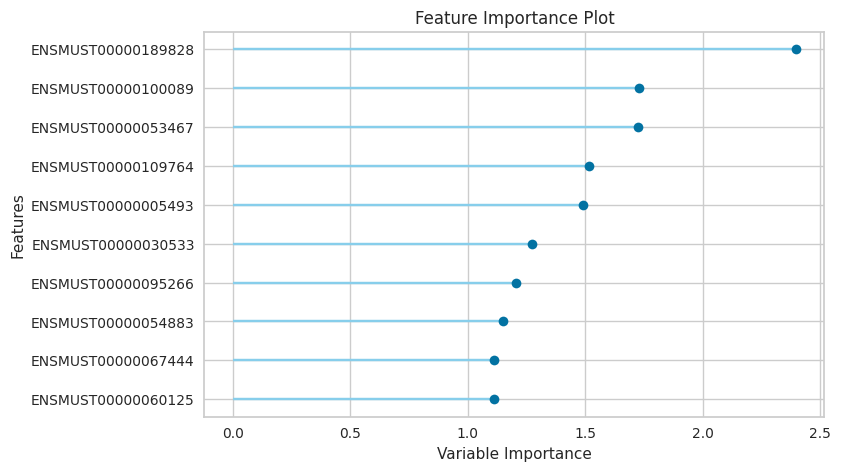

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0004,0.0000,0.0006,0.7743,0.0006,0.5099
1,0.0004,0.0000,0.0006,0.7671,0.0006,0.5210
2,0.0004,0.0000,0.0006,0.7670,0.0006,0.5061
3,0.0004,0.0000,0.0006,0.7710,0.0006,0.4907
4,0.0004,0.0000,0.0006,0.7609,0.0006,0.5055
Mean,0.0004,0.0000,0.0006,0.7681,0.0006,0.5066
Std,0.0000,0.0000,0.0000,0.0045,0.0000,0.0097


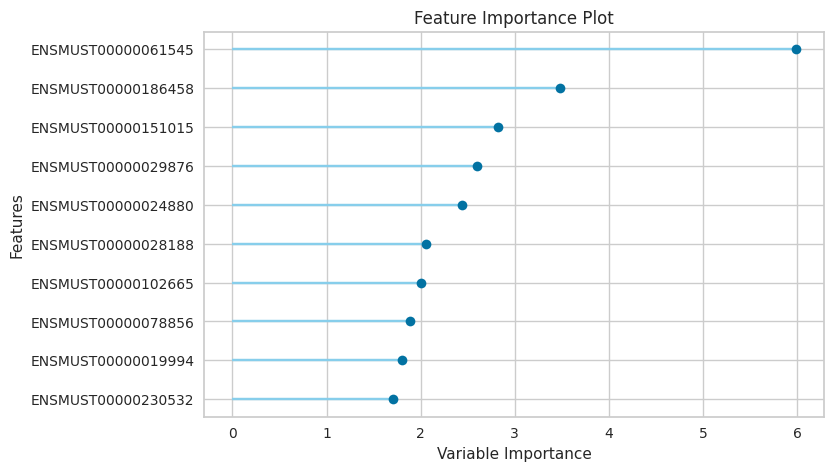

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,08:11:53
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Regressor


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
for i in range(len(y_train.columns)):
    # Extract the column name for the current index
    lipid_name = y_train.columns[i]

    # Concatenate the lipid column with the training and testing features
    train_data = pd.concat([X_train, y_train.iloc[:, i]], axis=1)
    test_data = pd.concat([X_test, y_test.iloc[:, i]], axis=1)
    
    # Setup PyCaret for each lipid
    # Ensure that the test dataset is correctly specified
    setup(data=train_data, test_data=test_data, 
          fold=5, session_id=42, use_gpu=True, verbose=False, preprocess=False)

    # Create and plot the model
    model = create_model('catboost')
    plot_model(model, plot='feature')

# Evaluating One Model using K-Cross Validation

In [ ]:
results_df = pd.DataFrame(columns=['Lipid', 'R2_mean', 'MAPE_mean'])

for i, lipid_name in enumerate(y_train.columns):
    # Extract the column name for the current index
    lipid_name = y_train.columns[i]

    # Concatenate the lipid column with the training and testing features
    train_data = pd.concat([X_train, y_train.iloc[:, i]], axis=1)
    test_data = pd.concat([X_test, y_test.iloc[:, i]], axis=1)
    
    # Setup PyCaret for each lipid
    # Ensure that the test dataset is correctly specified
    setup(data=train_data, test_data=test_data, 
          fold=5, session_id=42, use_gpu=True, verbose=False, preprocess=False)
    
    # Create and plot the model
    model = create_model('catboost')
    
    # Retrieving cross-validation results
    metrics = pull()
    
    r2_mean = metrics.loc['Mean','R2']
    mape_mean = metrics.loc['Mean', 'MAPE']
    
    print("R2 mean: ", r2_mean)
    print("MAPE mean: ", mape_mean)
    
    # Append the results to the DataFrame
    results_df = results_df.append({'Lipid': lipid_name, 'R2_mean': r2_mean, 'MAPE_mean': mape_mean}, ignore_index=True)

results_df

In [21]:
results_df.to_csv('results.csv')